In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_38283/2809884579.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


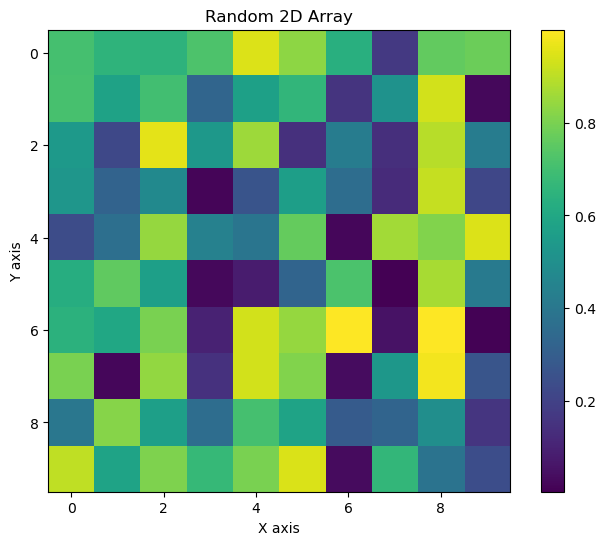

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 1000000,

                    OTTT_sWS_on = True, # True # False
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == False
    if BPTT_on == True:
        assert tdBN_on == False
    if convTrue_fcFalse == False:
        assert OTTT_sWS_on == False
    if pre_trained == True:
        print("\nCaution! pre_trained is True\n")    
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    wandb.config.update(hyperparameters)
    wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
    wandb.define_metric("summary_val_acc", summary="max")
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################


    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if pre_trained == False:
        if (convTrue_fcFalse == False):
            if (single_step == False):
                net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                            synapse_fc_trace_const1, synapse_fc_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on).to(device)
            else:
                net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                            synapse_fc_trace_const1, synapse_fc_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on).to(device)
        else:
            if (single_step == False):
                net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
            else:
                net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net) #나중에풀어줘
    else:
        net = torch.load(pre_trained_path)

    net = net.to(device)
    if (net_print == True):
        print(net)        
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
        ##################################################################################################



        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()

            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################
                    
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################



            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################


            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)

                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)


                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    # torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                    # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                    # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                    # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
            wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_best": val_acc}, step=i+epoch*len(train_loader))
            wandb.log({"summary_val_acc": val_acc_now})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # np.save(iter_acc_file_name_time, iter_acc_array)
            # np.save(tr_acc_file_name_time, iter_acc_array)
            # np.save(val_acc_file_name_time, val_acc_now_array)
            # with open(hyperparameters_file_name_time, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
            np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
            np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
            with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main_FINAL_TEST' ## 이거 설정하면 새로운 경로에 모두 save

wandb.init(project= f'my_snn {unique_name}',save_code=True)
my_snn_system(  devices = "4",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
                learning_rate = 0.1, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
                dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin



your OTTT_sWS_on True 

지금 ottt만해라. 아니면 data_loader와서 바꿔라
Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV_sstep(
    (layers): MY_Sequential(
      (0): SYNAPSE_CONV_trace_sstep()
      (1): LIF_layer_trace_sstep()
      (2): Scale()
      (3): SYNAPSE_CONV_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Scale()
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): SYNAPSE_CONV_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): Scale()
      (10): SYNAPSE_CONV_trace_sstep()
      (11): LIF_layer_trace_sstep()
      (12): Scale()
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): SYNAPSE_CONV_trace_sstep()
      (15): LIF_layer_trace_sstep()
      (16): Scale()
      (17): SYNAPSE_CONV_trace_sstep()
      (18): LIF_layer_trace_sstep()
      (19): Scale()
      (20): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (21): SYNAPSE_CONV_trace_sstep()
      (22): LIF_la

0-390/391 iter:51.25%, lr=['0.1'], iter_loss:0.20107761025428772, val:51.30%, val_best:51.30%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 169.05577731132507 seconds

EPOCH 1



1-390/391 iter:56.25%, lr=['0.09999725846827562'], iter_loss:0.17927539348602295, val:61.96%, val_best:61.96%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.49083304405212 seconds

EPOCH 2



2-390/391 iter:61.25%, lr=['0.09998903417374229'], iter_loss:0.132509246468544, val:69.28%, val_best:69.28%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 

epoch_time: 168.5743284225464 seconds

EPOCH 3



3-390/391 iter:67.50%, lr=['0.0999753280182866'], iter_loss:0.12502577900886536, val:72.55%, val_best:72.55%: 100%|██████████| 391/391 [02:48<00:00,  2.33it/s]

epoch_time: 168.23513340950012 seconds

EPOCH 4



4-390/391 iter:77.50%, lr=['0.09995614150494293'], iter_loss:0.1284729242324829, val:74.68%, val_best:74.68%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.93487739562988 seconds

EPOCH 5



5-390/391 iter:78.75%, lr=['0.0999314767377287'], iter_loss:0.1305341124534607, val:77.70%, val_best:77.70%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]

epoch_time: 169.87619042396545 seconds

EPOCH 6



6-390/391 iter:82.50%, lr=['0.09990133642141359'], iter_loss:0.1078263521194458, val:78.41%, val_best:78.41%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.9244658946991 seconds

EPOCH 7



7-390/391 iter:80.00%, lr=['0.0998657238612229'], iter_loss:0.10510968416929245, val:81.24%, val_best:81.24%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.55910062789917 seconds

EPOCH 8



8-390/391 iter:77.50%, lr=['0.09982464296247523'], iter_loss:0.0981367751955986, val:82.24%, val_best:82.24%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.61720776557922 seconds

EPOCH 9



9-390/391 iter:83.75%, lr=['0.099778098230154'], iter_loss:0.10181473940610886, val:82.26%, val_best:82.26%: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s]

epoch_time: 168.15939092636108 seconds

EPOCH 10



10-390/391 iter:78.75%, lr=['0.09972609476841367'], iter_loss:0.08810578286647797, val:83.44%, val_best:83.44%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.33402276039124 seconds

EPOCH 11



11-390/391 iter:90.00%, lr=['0.09966863828001983'], iter_loss:0.07724437117576599, val:83.69%, val_best:83.69%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.79108595848083 seconds

EPOCH 12



12-390/391 iter:86.25%, lr=['0.09960573506572391'], iter_loss:0.09879723191261292, val:84.08%, val_best:84.08%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.54839539527893 seconds

EPOCH 13



13-390/391 iter:75.00%, lr=['0.09953739202357219'], iter_loss:0.10015946626663208, val:86.45%, val_best:86.45%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 169.02748274803162 seconds

EPOCH 14



14-390/391 iter:88.75%, lr=['0.09946361664814943'], iter_loss:0.07616785913705826, val:86.02%, val_best:86.45%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 169.01983261108398 seconds

EPOCH 15



15-390/391 iter:88.75%, lr=['0.0993844170297569'], iter_loss:0.0728943794965744, val:86.20%, val_best:86.45%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.36618328094482 seconds

EPOCH 16



16-390/391 iter:78.75%, lr=['0.09929980185352526'], iter_loss:0.06408300250768661, val:86.66%, val_best:86.66%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 170.90436816215515 seconds

EPOCH 17



17-390/391 iter:92.50%, lr=['0.0992097803984621'], iter_loss:0.06312775611877441, val:87.46%, val_best:87.46%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]

epoch_time: 170.0217354297638 seconds

EPOCH 18



18-390/391 iter:86.25%, lr=['0.09911436253643445'], iter_loss:0.06840898096561432, val:87.66%, val_best:87.66%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.71389961242676 seconds

EPOCH 19



19-390/391 iter:86.25%, lr=['0.09901355873108611'], iter_loss:0.05826321244239807, val:88.11%, val_best:88.11%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.45253801345825 seconds

EPOCH 20



20-390/391 iter:93.75%, lr=['0.09890738003669029'], iter_loss:0.05992501601576805, val:88.39%, val_best:88.39%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.67124390602112 seconds

EPOCH 21



21-390/391 iter:87.50%, lr=['0.09879583809693737'], iter_loss:0.09801439940929413, val:88.13%, val_best:88.39%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.5941309928894 seconds

EPOCH 22



22-390/391 iter:88.75%, lr=['0.09867894514365802'], iter_loss:0.056194812059402466, val:88.72%, val_best:88.72%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.35320806503296 seconds

EPOCH 23



23-390/391 iter:86.25%, lr=['0.09855671399548181'], iter_loss:0.0779322013258934, val:89.65%, val_best:89.65%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.53535914421082 seconds

EPOCH 24



24-390/391 iter:92.50%, lr=['0.09842915805643157'], iter_loss:0.07039092481136322, val:88.94%, val_best:89.65%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.59806537628174 seconds

EPOCH 25



25-390/391 iter:93.75%, lr=['0.09829629131445343'], iter_loss:0.04811319708824158, val:89.61%, val_best:89.65%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 171.07075786590576 seconds

EPOCH 26



26-390/391 iter:93.75%, lr=['0.09815812833988292'], iter_loss:0.09218743443489075, val:89.64%, val_best:89.65%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]

epoch_time: 170.00472903251648 seconds

EPOCH 27



27-390/391 iter:91.25%, lr=['0.09801468428384717'], iter_loss:0.05873361974954605, val:89.28%, val_best:89.65%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.61105179786682 seconds

EPOCH 28



28-390/391 iter:87.50%, lr=['0.09786597487660338'], iter_loss:0.07823739945888519, val:89.14%, val_best:89.65%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.74214816093445 seconds

EPOCH 29



29-390/391 iter:90.00%, lr=['0.09771201642581387'], iter_loss:0.043724365532398224, val:89.51%, val_best:89.65%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 170.56716442108154 seconds

EPOCH 30



30-390/391 iter:91.25%, lr=['0.09755282581475772'], iter_loss:0.05683266744017601, val:89.70%, val_best:89.70%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]

epoch_time: 169.90305256843567 seconds

EPOCH 31



31-390/391 iter:93.75%, lr=['0.09738842050047931'], iter_loss:0.07588015496730804, val:90.32%, val_best:90.32%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.6336269378662 seconds

EPOCH 32



32-390/391 iter:93.75%, lr=['0.09721881851187408'], iter_loss:0.05188876390457153, val:90.02%, val_best:90.32%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s]

epoch_time: 170.27121686935425 seconds

EPOCH 33



33-390/391 iter:97.50%, lr=['0.0970440384477113'], iter_loss:0.05119439214468002, val:90.62%, val_best:90.62%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s]

epoch_time: 170.3867781162262 seconds

EPOCH 34



34-390/391 iter:95.00%, lr=['0.0968640994745946'], iter_loss:0.05642607808113098, val:90.62%, val_best:90.62%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.69296884536743 seconds

EPOCH 35



35-390/391 iter:88.75%, lr=['0.0966790213248601'], iter_loss:0.05918886512517929, val:90.31%, val_best:90.62%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 172.8976092338562 seconds

EPOCH 36



36-390/391 iter:90.00%, lr=['0.09648882429441259'], iter_loss:0.05223298817873001, val:90.21%, val_best:90.62%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.30359196662903 seconds

EPOCH 37



37-390/391 iter:96.25%, lr=['0.09629352924049978'], iter_loss:0.040894459933042526, val:90.43%, val_best:90.62%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.92771315574646 seconds

EPOCH 38



38-390/391 iter:95.00%, lr=['0.09609315757942506'], iter_loss:0.04774590954184532, val:90.52%, val_best:90.62%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.2636046409607 seconds

EPOCH 39



39-390/391 iter:97.50%, lr=['0.09588773128419908'], iter_loss:0.0626898854970932, val:90.58%, val_best:90.62%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.19987273216248 seconds

EPOCH 40



40-390/391 iter:93.75%, lr=['0.09567727288213007'], iter_loss:0.0535808727145195, val:90.93%, val_best:90.93%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 174.0904257297516 seconds

EPOCH 41



41-390/391 iter:96.25%, lr=['0.09546180545235346'], iter_loss:0.04887690767645836, val:91.13%, val_best:91.13%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.9350311756134 seconds

EPOCH 42



42-390/391 iter:95.00%, lr=['0.09524135262330101'], iter_loss:0.07414313405752182, val:90.94%, val_best:91.13%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 173.1238555908203 seconds

EPOCH 43



43-390/391 iter:96.25%, lr=['0.09501593857010972'], iter_loss:0.051436956971883774, val:91.03%, val_best:91.13%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 178.01604771614075 seconds

EPOCH 44



44-390/391 iter:93.75%, lr=['0.09478558801197068'], iter_loss:0.0392087921500206, val:91.19%, val_best:91.19%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.28437638282776 seconds

EPOCH 45



45-390/391 iter:92.50%, lr=['0.09455032620941842'], iter_loss:0.04680638015270233, val:90.71%, val_best:91.19%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.83174896240234 seconds

EPOCH 46



46-390/391 iter:95.00%, lr=['0.09431017896156076'], iter_loss:0.047316357493400574, val:90.70%, val_best:91.19%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.68653178215027 seconds

EPOCH 47



47-390/391 iter:97.50%, lr=['0.09406517260324962'], iter_loss:0.05999450013041496, val:91.31%, val_best:91.31%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.77715802192688 seconds

EPOCH 48



48-390/391 iter:96.25%, lr=['0.09381533400219319'], iter_loss:0.04248769208788872, val:90.87%, val_best:91.31%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.93878841400146 seconds

EPOCH 49



49-390/391 iter:93.75%, lr=['0.09356069055600949'], iter_loss:0.06309326738119125, val:91.27%, val_best:91.31%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.70387864112854 seconds

EPOCH 50



50-390/391 iter:97.50%, lr=['0.09330127018922195'], iter_loss:0.04858166724443436, val:91.21%, val_best:91.31%: 100%|██████████| 391/391 [02:51<00:00,  2.27it/s] 

epoch_time: 172.1138777732849 seconds

EPOCH 51



51-390/391 iter:97.50%, lr=['0.0930371013501972'], iter_loss:0.06137268990278244, val:91.04%, val_best:91.31%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.50693202018738 seconds

EPOCH 52



52-390/391 iter:97.50%, lr=['0.09276821300802535'], iter_loss:0.04052979499101639, val:90.95%, val_best:91.31%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s] 

epoch_time: 170.48620748519897 seconds

EPOCH 53



53-390/391 iter:97.50%, lr=['0.09249463464934321'], iter_loss:0.055176686495542526, val:91.54%, val_best:91.54%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 170.91611671447754 seconds

EPOCH 54



54-390/391 iter:97.50%, lr=['0.09221639627510077'], iter_loss:0.057464130222797394, val:91.27%, val_best:91.54%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.51629066467285 seconds

EPOCH 55



55-390/391 iter:97.50%, lr=['0.09193352839727122'], iter_loss:0.03927318751811981, val:91.57%, val_best:91.57%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.25234842300415 seconds

EPOCH 56



56-390/391 iter:100.00%, lr=['0.09164606203550499'], iter_loss:0.05446262285113335, val:91.64%, val_best:91.64%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.22894597053528 seconds

EPOCH 57



57-390/391 iter:96.25%, lr=['0.0913540287137281'], iter_loss:0.028420528396964073, val:91.57%, val_best:91.64%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s]

epoch_time: 170.4597315788269 seconds

EPOCH 58



58-390/391 iter:97.50%, lr=['0.09105746045668521'], iter_loss:0.04711022973060608, val:91.55%, val_best:91.64%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.5311005115509 seconds

EPOCH 59



59-390/391 iter:95.00%, lr=['0.09075638978642771'], iter_loss:0.03839707374572754, val:91.60%, val_best:91.64%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.53151440620422 seconds

EPOCH 60



60-390/391 iter:98.75%, lr=['0.09045084971874738'], iter_loss:0.05158696696162224, val:91.29%, val_best:91.64%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s] 

epoch_time: 170.59715390205383 seconds

EPOCH 61



61-390/391 iter:96.25%, lr=['0.09014087375955573'], iter_loss:0.08135181665420532, val:91.99%, val_best:91.99%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.95946335792542 seconds

EPOCH 62



62-390/391 iter:98.75%, lr=['0.08982649590120982'], iter_loss:0.03357740119099617, val:92.09%, val_best:92.09%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.4615194797516 seconds

EPOCH 63



63-390/391 iter:96.25%, lr=['0.08950775061878452'], iter_loss:0.0431801974773407, val:91.85%, val_best:92.09%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s]  

epoch_time: 170.3035409450531 seconds

EPOCH 64



64-390/391 iter:95.00%, lr=['0.089184672866292'], iter_loss:0.03632287681102753, val:91.93%, val_best:92.09%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.3111515045166 seconds

EPOCH 65



65-390/391 iter:96.25%, lr=['0.08885729807284856'], iter_loss:0.03411165624856949, val:91.74%, val_best:92.09%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s] 

epoch_time: 170.33633661270142 seconds

EPOCH 66



66-390/391 iter:97.50%, lr=['0.08852566213878947'], iter_loss:0.08943848311901093, val:91.64%, val_best:92.09%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s] 

epoch_time: 170.94076776504517 seconds

EPOCH 67



67-390/391 iter:97.50%, lr=['0.08818980143173213'], iter_loss:0.043821316212415695, val:91.81%, val_best:92.09%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.41392993927002 seconds

EPOCH 68



68-390/391 iter:100.00%, lr=['0.08784975278258783'], iter_loss:0.04815258830785751, val:91.46%, val_best:92.09%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 171.14497828483582 seconds

EPOCH 69



69-390/391 iter:97.50%, lr=['0.08750555348152299'], iter_loss:0.046572111546993256, val:91.73%, val_best:92.09%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]

epoch_time: 169.98164701461792 seconds

EPOCH 70



70-390/391 iter:97.50%, lr=['0.08715724127386973'], iter_loss:0.026784192770719528, val:92.11%, val_best:92.11%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s]

epoch_time: 170.32532358169556 seconds

EPOCH 71



71-390/391 iter:96.25%, lr=['0.08680485435598673'], iter_loss:0.05150297284126282, val:91.63%, val_best:92.11%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.70666027069092 seconds

EPOCH 72



72-390/391 iter:97.50%, lr=['0.0864484313710706'], iter_loss:0.03964802622795105, val:91.72%, val_best:92.11%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.9293978214264 seconds

EPOCH 73



73-390/391 iter:97.50%, lr=['0.08608801140491813'], iter_loss:0.041517697274684906, val:91.66%, val_best:92.11%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.4104607105255 seconds

EPOCH 74



74-390/391 iter:97.50%, lr=['0.0857236339816402'], iter_loss:0.04465727508068085, val:92.03%, val_best:92.11%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s] 

epoch_time: 169.9201328754425 seconds

EPOCH 75



75-390/391 iter:98.75%, lr=['0.0853553390593274'], iter_loss:0.059168338775634766, val:91.73%, val_best:92.11%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.81277346611023 seconds

EPOCH 76



76-390/391 iter:98.75%, lr=['0.08498316702566831'], iter_loss:0.04865571856498718, val:91.89%, val_best:92.11%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.45271015167236 seconds

EPOCH 77



77-390/391 iter:95.00%, lr=['0.08460715869352037'], iter_loss:0.04869433492422104, val:91.91%, val_best:92.11%: 100%|██████████| 391/391 [02:51<00:00,  2.29it/s] 

epoch_time: 171.26500821113586 seconds

EPOCH 78



78-390/391 iter:95.00%, lr=['0.08422735529643446'], iter_loss:0.038276009261608124, val:92.06%, val_best:92.11%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 170.62691020965576 seconds

EPOCH 79



79-390/391 iter:97.50%, lr=['0.08384379848413306'], iter_loss:0.05289936065673828, val:92.16%, val_best:92.16%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s] 

epoch_time: 170.48521447181702 seconds

EPOCH 80



80-390/391 iter:98.75%, lr=['0.08345653031794294'], iter_loss:0.06616541743278503, val:91.97%, val_best:92.16%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.25061964988708 seconds

EPOCH 81



81-390/391 iter:98.75%, lr=['0.08306559326618262'], iter_loss:0.040445201098918915, val:91.75%, val_best:92.16%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 170.97568488121033 seconds

EPOCH 82



82-390/391 iter:100.00%, lr=['0.08267103019950531'], iter_loss:0.06008937209844589, val:92.36%, val_best:92.36%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.4485764503479 seconds

EPOCH 83



83-390/391 iter:97.50%, lr=['0.08227288438619755'], iter_loss:0.08175034821033478, val:91.93%, val_best:92.36%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s] 

epoch_time: 170.04278230667114 seconds

EPOCH 84



84-390/391 iter:97.50%, lr=['0.0818711994874345'], iter_loss:0.05093483254313469, val:91.99%, val_best:92.36%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.73278260231018 seconds

EPOCH 85



85-390/391 iter:97.50%, lr=['0.08146601955249189'], iter_loss:0.0526113286614418, val:92.35%, val_best:92.36%: 100%|██████████| 391/391 [02:51<00:00,  2.27it/s]  

epoch_time: 172.06913137435913 seconds

EPOCH 86



86-390/391 iter:96.25%, lr=['0.08105738901391554'], iter_loss:0.07491075992584229, val:92.12%, val_best:92.36%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.20391297340393 seconds

EPOCH 87



87-390/391 iter:97.50%, lr=['0.08064535268264884'], iter_loss:0.06434357166290283, val:92.34%, val_best:92.36%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 173.7584207057953 seconds

EPOCH 88



88-390/391 iter:98.75%, lr=['0.08022995574311877'], iter_loss:0.05541383847594261, val:92.11%, val_best:92.36%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 173.81966614723206 seconds

EPOCH 89



89-390/391 iter:100.00%, lr=['0.0798112437482808'], iter_loss:0.0478665828704834, val:92.06%, val_best:92.36%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 174.02214407920837 seconds

EPOCH 90



90-390/391 iter:98.75%, lr=['0.07938926261462366'], iter_loss:0.0742441862821579, val:92.31%, val_best:92.36%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]  

epoch_time: 172.77389883995056 seconds

EPOCH 91



91-390/391 iter:97.50%, lr=['0.07896405861713394'], iter_loss:0.06144505366683006, val:92.44%, val_best:92.44%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.83781218528748 seconds

EPOCH 92



92-390/391 iter:97.50%, lr=['0.0785356783842216'], iter_loss:0.06418047845363617, val:91.90%, val_best:92.44%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.50131511688232 seconds

EPOCH 93



93-390/391 iter:97.50%, lr=['0.07810416889260655'], iter_loss:0.0739966556429863, val:92.44%, val_best:92.44%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]  

epoch_time: 173.96651649475098 seconds

EPOCH 94



94-390/391 iter:97.50%, lr=['0.07766957746216721'], iter_loss:0.053974609822034836, val:91.95%, val_best:92.44%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.52144861221313 seconds

EPOCH 95



95-390/391 iter:97.50%, lr=['0.07723195175075136'], iter_loss:0.10063367336988449, val:91.85%, val_best:92.44%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 

epoch_time: 177.15897727012634 seconds

EPOCH 96



96-390/391 iter:97.50%, lr=['0.07679133974894983'], iter_loss:0.06445655971765518, val:92.14%, val_best:92.44%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.2472860813141 seconds

EPOCH 97



97-390/391 iter:98.75%, lr=['0.07634778977483389'], iter_loss:0.06598617136478424, val:92.47%, val_best:92.47%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.46626496315002 seconds

EPOCH 98



98-390/391 iter:96.25%, lr=['0.07590135046865652'], iter_loss:0.05723501369357109, val:91.95%, val_best:92.47%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 173.61431908607483 seconds

EPOCH 99



99-390/391 iter:98.75%, lr=['0.07545207078751857'], iter_loss:0.06950345635414124, val:92.09%, val_best:92.47%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 177.78260612487793 seconds

EPOCH 100



100-390/391 iter:98.75%, lr=['0.07500000000000001'], iter_loss:0.05030374974012375, val:92.31%, val_best:92.47%: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s] 

epoch_time: 181.45258736610413 seconds

EPOCH 101



101-390/391 iter:100.00%, lr=['0.07454518768075706'], iter_loss:0.0639931708574295, val:92.35%, val_best:92.47%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 177.9096953868866 seconds

EPOCH 102



102-390/391 iter:100.00%, lr=['0.07408768370508578'], iter_loss:0.06403933465480804, val:92.19%, val_best:92.47%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 176.68959546089172 seconds

EPOCH 103



103-390/391 iter:100.00%, lr=['0.07362753824345272'], iter_loss:0.040306802839040756, val:92.51%, val_best:92.51%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.80006551742554 seconds

EPOCH 104



104-390/391 iter:100.00%, lr=['0.07316480175599312'], iter_loss:0.06559528410434723, val:92.27%, val_best:92.51%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]

epoch_time: 184.18858122825623 seconds

EPOCH 105



105-390/391 iter:97.50%, lr=['0.07269952498697736'], iter_loss:0.08075536787509918, val:92.33%, val_best:92.51%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 181.76058983802795 seconds

EPOCH 106



106-390/391 iter:98.75%, lr=['0.0722317589592464'], iter_loss:0.04955969750881195, val:92.39%, val_best:92.51%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s] 

epoch_time: 178.71142601966858 seconds

EPOCH 107



107-390/391 iter:95.00%, lr=['0.0717615549686164'], iter_loss:0.09496608376502991, val:92.53%, val_best:92.53%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.5975980758667 seconds

EPOCH 108



108-390/391 iter:98.75%, lr=['0.07128896457825365'], iter_loss:0.04757615923881531, val:92.37%, val_best:92.53%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.62657475471497 seconds

EPOCH 109



109-390/391 iter:96.25%, lr=['0.07081403961302007'], iter_loss:0.03615579009056091, val:92.24%, val_best:92.53%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s] 

epoch_time: 181.07790732383728 seconds

EPOCH 110



110-390/391 iter:97.50%, lr=['0.07033683215379001'], iter_loss:0.06315619498491287, val:92.44%, val_best:92.53%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s] 

epoch_time: 194.07928347587585 seconds

EPOCH 111



111-390/391 iter:97.50%, lr=['0.06985739453173903'], iter_loss:0.060132093727588654, val:92.44%, val_best:92.53%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.30060243606567 seconds

EPOCH 112



112-390/391 iter:100.00%, lr=['0.06937577932260515'], iter_loss:0.06827397644519806, val:92.54%, val_best:92.54%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.3433177471161 seconds

EPOCH 113



113-390/391 iter:97.50%, lr=['0.06889203934092336'], iter_loss:0.04939781129360199, val:92.56%, val_best:92.56%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s] 

epoch_time: 173.13978815078735 seconds

EPOCH 114



114-390/391 iter:95.00%, lr=['0.0684062276342339'], iter_loss:0.066472627222538, val:92.47%, val_best:92.56%: 100%|██████████| 391/391 [02:51<00:00,  2.27it/s]   

epoch_time: 172.11261463165283 seconds

EPOCH 115



115-390/391 iter:98.75%, lr=['0.067918397477265'], iter_loss:0.07288607954978943, val:92.38%, val_best:92.56%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.95631623268127 seconds

EPOCH 116



116-390/391 iter:100.00%, lr=['0.06742860236609076'], iter_loss:0.08420264720916748, val:92.54%, val_best:92.56%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.44441103935242 seconds

EPOCH 117



117-390/391 iter:100.00%, lr=['0.06693689601226457'], iter_loss:0.0648099035024643, val:92.48%, val_best:92.56%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.34459972381592 seconds

EPOCH 118



118-390/391 iter:98.75%, lr=['0.06644333233692916'], iter_loss:0.07407538592815399, val:92.28%, val_best:92.56%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.56110334396362 seconds

EPOCH 119



119-390/391 iter:100.00%, lr=['0.0659479654649035'], iter_loss:0.07951885461807251, val:92.36%, val_best:92.56%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 171.09365391731262 seconds

EPOCH 120



120-390/391 iter:97.50%, lr=['0.06545084971874737'], iter_loss:0.06665860116481781, val:92.70%, val_best:92.70%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.42342162132263 seconds

EPOCH 121



121-390/391 iter:100.00%, lr=['0.06495203961280434'], iter_loss:0.0522526353597641, val:92.60%, val_best:92.70%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.80038571357727 seconds

EPOCH 122



122-390/391 iter:98.75%, lr=['0.06445158984722359'], iter_loss:0.05963937193155289, val:92.62%, val_best:92.70%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.52617120742798 seconds

EPOCH 123



123-390/391 iter:97.50%, lr=['0.06394955530196147'], iter_loss:0.06772934645414352, val:92.76%, val_best:92.76%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 173.6194612979889 seconds

EPOCH 124



124-390/391 iter:98.75%, lr=['0.06344599103076329'], iter_loss:0.06436923146247864, val:92.59%, val_best:92.76%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.41598463058472 seconds

EPOCH 125



125-390/391 iter:98.75%, lr=['0.06294095225512605'], iter_loss:0.0696084201335907, val:92.77%, val_best:92.77%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]  

epoch_time: 174.00927257537842 seconds

EPOCH 126



126-390/391 iter:97.50%, lr=['0.062434494358242734'], iter_loss:0.06010940670967102, val:92.74%, val_best:92.77%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.30322217941284 seconds

EPOCH 127



127-390/391 iter:98.75%, lr=['0.06192667287892904'], iter_loss:0.0566830150783062, val:92.33%, val_best:92.77%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]  

epoch_time: 172.7545120716095 seconds

EPOCH 128



128-390/391 iter:98.75%, lr=['0.06141754350553279'], iter_loss:0.06432919204235077, val:92.77%, val_best:92.77%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s] 

epoch_time: 172.81851649284363 seconds

EPOCH 129



129-390/391 iter:100.00%, lr=['0.06090716206982714'], iter_loss:0.0681888610124588, val:92.22%, val_best:92.77%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.45562028884888 seconds

EPOCH 130



130-390/391 iter:98.75%, lr=['0.06039558454088797'], iter_loss:0.08305440843105316, val:92.48%, val_best:92.77%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.4380922317505 seconds

EPOCH 131



131-390/391 iter:97.50%, lr=['0.059882867018956294'], iter_loss:0.04347897320985794, val:92.63%, val_best:92.77%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.73877263069153 seconds

EPOCH 132



132-390/391 iter:98.75%, lr=['0.05936906572928624'], iter_loss:0.04932968318462372, val:92.61%, val_best:92.77%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.59184646606445 seconds

EPOCH 133



133-390/391 iter:95.00%, lr=['0.05885423701597917'], iter_loss:0.06694193184375763, val:92.59%, val_best:92.77%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.355872631073 seconds

EPOCH 134



134-390/391 iter:100.00%, lr=['0.05833843733580512'], iter_loss:0.08163566887378693, val:92.57%, val_best:92.77%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.4947371482849 seconds

EPOCH 135



135-390/391 iter:97.50%, lr=['0.057821723252011556'], iter_loss:0.05903094261884689, val:92.68%, val_best:92.77%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 173.58083295822144 seconds

EPOCH 136



136-390/391 iter:100.00%, lr=['0.0573041514281206'], iter_loss:0.045965131372213364, val:92.76%, val_best:92.77%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.68638610839844 seconds

EPOCH 137



137-390/391 iter:98.75%, lr=['0.05678577862171523'], iter_loss:0.06797472387552261, val:92.82%, val_best:92.82%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.2187216281891 seconds

EPOCH 138



138-390/391 iter:100.00%, lr=['0.05626666167821522'], iter_loss:0.054972320795059204, val:92.85%, val_best:92.85%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.88375091552734 seconds

EPOCH 139



139-390/391 iter:97.50%, lr=['0.055746857524643346'], iter_loss:0.054222047328948975, val:92.51%, val_best:92.85%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s]

epoch_time: 176.06362223625183 seconds

EPOCH 140



140-390/391 iter:98.75%, lr=['0.0552264231633827'], iter_loss:0.05343712493777275, val:92.78%, val_best:92.85%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s] 

epoch_time: 178.42642211914062 seconds

EPOCH 141



141-390/391 iter:100.00%, lr=['0.05470541566592574'], iter_loss:0.07425585389137268, val:92.53%, val_best:92.85%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.5040647983551 seconds

EPOCH 142



142-390/391 iter:100.00%, lr=['0.05418389216661579'], iter_loss:0.07199229300022125, val:92.51%, val_best:92.85%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]

epoch_time: 178.65888476371765 seconds

EPOCH 143



143-390/391 iter:97.50%, lr=['0.0536619098563816'], iter_loss:0.06852558255195618, val:92.81%, val_best:92.85%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.33861207962036 seconds

EPOCH 144



144-390/391 iter:98.75%, lr=['0.053139525976465686'], iter_loss:0.06353520601987839, val:92.89%, val_best:92.89%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s] 

epoch_time: 173.08575201034546 seconds

EPOCH 145



145-390/391 iter:96.25%, lr=['0.05261679781214721'], iter_loss:0.07984572649002075, val:92.72%, val_best:92.89%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.45836472511292 seconds

EPOCH 146



146-390/391 iter:98.75%, lr=['0.05209378268646'], iter_loss:0.07406195998191833, val:92.81%, val_best:92.89%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.54661011695862 seconds

EPOCH 147



147-390/391 iter:98.75%, lr=['0.05157053795390641'], iter_loss:0.06667479872703552, val:92.77%, val_best:92.89%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.58325171470642 seconds

EPOCH 148



148-390/391 iter:97.50%, lr=['0.051047120994167854'], iter_loss:0.07326804101467133, val:92.54%, val_best:92.89%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.68738436698914 seconds

EPOCH 149



149-390/391 iter:100.00%, lr=['0.0505235892058123'], iter_loss:0.07191118597984314, val:93.00%, val_best:93.00%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 172.9842631816864 seconds

EPOCH 150



150-390/391 iter:98.75%, lr=['0.05000000000000001'], iter_loss:0.07131259143352509, val:93.10%, val_best:93.10%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.44214630126953 seconds

EPOCH 151



151-390/391 iter:100.00%, lr=['0.04947641079418772'], iter_loss:0.04384745657444, val:92.99%, val_best:93.10%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]   

epoch_time: 175.51245641708374 seconds

EPOCH 152



152-390/391 iter:98.75%, lr=['0.04895287900583217'], iter_loss:0.047229938209056854, val:92.53%, val_best:93.10%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.39830350875854 seconds

EPOCH 153



153-390/391 iter:100.00%, lr=['0.048429462046093594'], iter_loss:0.07497113943099976, val:92.75%, val_best:93.10%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.69605827331543 seconds

EPOCH 154



154-390/391 iter:100.00%, lr=['0.04790621731354002'], iter_loss:0.053611960262060165, val:92.79%, val_best:93.10%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]

epoch_time: 177.22542190551758 seconds

EPOCH 155



155-390/391 iter:98.75%, lr=['0.04738320218785281'], iter_loss:0.07131637632846832, val:93.07%, val_best:93.10%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 177.63479709625244 seconds

EPOCH 156



156-390/391 iter:96.25%, lr=['0.04686047402353434'], iter_loss:0.048327088356018066, val:92.83%, val_best:93.10%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.88431072235107 seconds

EPOCH 157



157-390/391 iter:100.00%, lr=['0.04633809014361842'], iter_loss:0.048921942710876465, val:92.83%, val_best:93.10%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.7263367176056 seconds

EPOCH 158



158-390/391 iter:96.25%, lr=['0.04581610783338422'], iter_loss:0.06435829401016235, val:92.71%, val_best:93.10%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.90674424171448 seconds

EPOCH 159



159-390/391 iter:98.75%, lr=['0.045294584334074274'], iter_loss:0.06040626019239426, val:92.72%, val_best:93.10%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 

epoch_time: 180.38297271728516 seconds

EPOCH 160



160-390/391 iter:97.50%, lr=['0.044773576836617326'], iter_loss:0.03899866342544556, val:92.75%, val_best:93.10%: 100%|██████████| 391/391 [03:03<00:00,  2.14it/s] 

epoch_time: 183.2208275794983 seconds

EPOCH 161



161-390/391 iter:96.25%, lr=['0.044253142475356666'], iter_loss:0.07984280586242676, val:92.76%, val_best:93.10%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s] 

epoch_time: 180.98305439949036 seconds

EPOCH 162



162-390/391 iter:96.25%, lr=['0.04373333832178478'], iter_loss:0.04284481331706047, val:93.10%, val_best:93.10%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 173.7944254875183 seconds

EPOCH 163



163-390/391 iter:98.75%, lr=['0.043214221378284776'], iter_loss:0.04937506839632988, val:92.96%, val_best:93.10%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 174.12450742721558 seconds

EPOCH 164



164-390/391 iter:97.50%, lr=['0.04269584857187943'], iter_loss:0.04401978850364685, val:92.87%, val_best:93.10%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 

epoch_time: 182.74262714385986 seconds

EPOCH 165



165-390/391 iter:100.00%, lr=['0.042178276747988463'], iter_loss:0.04734545201063156, val:92.93%, val_best:93.10%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 172.91188097000122 seconds

EPOCH 166



166-390/391 iter:98.75%, lr=['0.04166156266419487'], iter_loss:0.04511424899101257, val:93.06%, val_best:93.10%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.93599438667297 seconds

EPOCH 167



167-390/391 iter:98.75%, lr=['0.04114576298402083'], iter_loss:0.044397905468940735, val:93.23%, val_best:93.23%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 174.13534545898438 seconds

EPOCH 168



168-390/391 iter:97.50%, lr=['0.040630934270713764'], iter_loss:0.04682868346571922, val:92.94%, val_best:93.23%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 175.06082367897034 seconds

EPOCH 169



169-390/391 iter:98.75%, lr=['0.040117132981043684'], iter_loss:0.03710111975669861, val:92.97%, val_best:93.23%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.35469555854797 seconds

EPOCH 170



170-390/391 iter:98.75%, lr=['0.03960441545911202'], iter_loss:0.04216387867927551, val:93.07%, val_best:93.23%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 

epoch_time: 177.1483564376831 seconds

EPOCH 171



171-390/391 iter:98.75%, lr=['0.03909283793017287'], iter_loss:0.055797278881073, val:93.00%, val_best:93.23%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]   

epoch_time: 179.60455131530762 seconds

EPOCH 172



172-390/391 iter:100.00%, lr=['0.03858245649446722'], iter_loss:0.05577428266406059, val:92.83%, val_best:93.23%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.33142066001892 seconds

EPOCH 173



173-390/391 iter:97.50%, lr=['0.03807332712107096'], iter_loss:0.03730633482336998, val:93.06%, val_best:93.23%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.62358856201172 seconds

EPOCH 174



174-390/391 iter:100.00%, lr=['0.037565505641757264'], iter_loss:0.061878036707639694, val:93.07%, val_best:93.23%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 176.8244824409485 seconds

EPOCH 175



175-390/391 iter:100.00%, lr=['0.037059047744873966'], iter_loss:0.05364867299795151, val:93.25%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]

epoch_time: 179.0065474510193 seconds

EPOCH 176



176-390/391 iter:97.50%, lr=['0.036554008969236725'], iter_loss:0.03545662760734558, val:92.84%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s] 

epoch_time: 175.93750739097595 seconds

EPOCH 177



177-390/391 iter:98.75%, lr=['0.036050444698038524'], iter_loss:0.04737924784421921, val:93.09%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.23it/s] 

epoch_time: 175.14028024673462 seconds

EPOCH 178



178-390/391 iter:98.75%, lr=['0.035548410152776405'], iter_loss:0.0597953125834465, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.25it/s]  

epoch_time: 174.21291065216064 seconds

EPOCH 179



179-390/391 iter:100.00%, lr=['0.03504796038719567'], iter_loss:0.051646023988723755, val:92.95%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]

epoch_time: 177.2068657875061 seconds

EPOCH 180



180-390/391 iter:100.00%, lr=['0.034549150281252626'], iter_loss:0.05932163447141647, val:93.04%, val_best:93.25%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.1837236881256 seconds

EPOCH 181



181-390/391 iter:100.00%, lr=['0.0340520345350965'], iter_loss:0.033642567694187164, val:92.71%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 177.16001558303833 seconds

EPOCH 182



182-390/391 iter:100.00%, lr=['0.03355666766307083'], iter_loss:0.05386088788509369, val:92.95%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.78554558753967 seconds

EPOCH 183



183-390/391 iter:98.75%, lr=['0.033063103987735425'], iter_loss:0.030228352174162865, val:92.98%, val_best:93.25%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s]

epoch_time: 181.10498642921448 seconds

EPOCH 184



184-390/391 iter:100.00%, lr=['0.03257139763390924'], iter_loss:0.05089908093214035, val:92.73%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 175.02672457695007 seconds

EPOCH 185



185-390/391 iter:98.75%, lr=['0.03208160252273499'], iter_loss:0.04901779815554619, val:92.91%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 178.1433310508728 seconds

EPOCH 186



186-390/391 iter:95.00%, lr=['0.031593772365766104'], iter_loss:0.040878765285015106, val:93.06%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 177.00439453125 seconds

EPOCH 187



187-390/391 iter:98.75%, lr=['0.031107960659076627'], iter_loss:0.04933729022741318, val:92.92%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 177.5921790599823 seconds

EPOCH 188



188-390/391 iter:100.00%, lr=['0.030624220677394842'], iter_loss:0.0483383946120739, val:93.01%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.5812919139862 seconds

EPOCH 189



189-390/391 iter:98.75%, lr=['0.03014260546826095'], iter_loss:0.05819873511791229, val:92.93%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s] 

epoch_time: 176.03567171096802 seconds

EPOCH 190



190-390/391 iter:97.50%, lr=['0.029663167846209974'], iter_loss:0.04886031895875931, val:92.87%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.33262991905212 seconds

EPOCH 191



191-390/391 iter:98.75%, lr=['0.029185960386979938'], iter_loss:0.06305310130119324, val:92.84%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.5356526374817 seconds

EPOCH 192



192-390/391 iter:97.50%, lr=['0.028711035421746356'], iter_loss:0.05892791599035263, val:93.07%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 173.97592616081238 seconds

EPOCH 193



193-390/391 iter:98.75%, lr=['0.02823844503138362'], iter_loss:0.06273593008518219, val:92.95%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 

epoch_time: 176.71371984481812 seconds

EPOCH 194



194-390/391 iter:98.75%, lr=['0.027768241040753625'], iter_loss:0.04725480079650879, val:92.93%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.29852652549744 seconds

EPOCH 195



195-390/391 iter:100.00%, lr=['0.02730047501302265'], iter_loss:0.06326638907194138, val:92.94%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.24122619628906 seconds

EPOCH 196



196-390/391 iter:100.00%, lr=['0.026835198244006913'], iter_loss:0.04846499115228653, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.6824734210968 seconds

EPOCH 197



197-390/391 iter:100.00%, lr=['0.026372461756547293'], iter_loss:0.05152979493141174, val:93.06%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.93552827835083 seconds

EPOCH 198



198-390/391 iter:100.00%, lr=['0.025912316294914216'], iter_loss:0.06771549582481384, val:93.07%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.28697085380554 seconds

EPOCH 199



199-390/391 iter:97.50%, lr=['0.025454812319242945'], iter_loss:0.042692169547080994, val:92.95%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.18209266662598 seconds

EPOCH 200



200-390/391 iter:100.00%, lr=['0.024999999999999974'], iter_loss:0.06672915816307068, val:92.89%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.43468761444092 seconds

EPOCH 201



201-390/391 iter:98.75%, lr=['0.02454792921248142'], iter_loss:0.052020471543073654, val:92.89%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.68116784095764 seconds

EPOCH 202



202-390/391 iter:100.00%, lr=['0.024098649531343483'], iter_loss:0.059917520731687546, val:92.96%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.54728841781616 seconds

EPOCH 203



203-390/391 iter:98.75%, lr=['0.023652210225166108'], iter_loss:0.06662652641534805, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 173.57049751281738 seconds

EPOCH 204



204-390/391 iter:98.75%, lr=['0.023208660251050166'], iter_loss:0.03759460151195526, val:92.88%, val_best:93.25%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.76131772994995 seconds

EPOCH 205



205-390/391 iter:100.00%, lr=['0.02276804824924865'], iter_loss:0.04426717758178711, val:92.80%, val_best:93.25%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 172.837739944458 seconds

EPOCH 206



206-390/391 iter:98.75%, lr=['0.022330422537832784'], iter_loss:0.06892900168895721, val:92.85%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.25it/s] 

epoch_time: 174.19622015953064 seconds

EPOCH 207



207-390/391 iter:100.00%, lr=['0.021895831107393467'], iter_loss:0.04090012237429619, val:92.97%, val_best:93.25%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.44335293769836 seconds

EPOCH 208



208-390/391 iter:100.00%, lr=['0.021464321615778405'], iter_loss:0.03704407066106796, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.91860675811768 seconds

EPOCH 209



209-390/391 iter:100.00%, lr=['0.021035941382866036'], iter_loss:0.054127685725688934, val:93.10%, val_best:93.25%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 173.12400317192078 seconds

EPOCH 210



210-390/391 iter:98.75%, lr=['0.020610737385376332'], iter_loss:0.050653159618377686, val:93.10%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]

epoch_time: 177.42403602600098 seconds

EPOCH 211



211-390/391 iter:97.50%, lr=['0.020188756251719186'], iter_loss:0.04746408760547638, val:92.84%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 177.57144832611084 seconds

EPOCH 212



212-390/391 iter:98.75%, lr=['0.019770044256881242'], iter_loss:0.06002674624323845, val:92.80%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.73541045188904 seconds

EPOCH 213



213-390/391 iter:100.00%, lr=['0.019354647317351172'], iter_loss:0.07826977968215942, val:92.85%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.4363658428192 seconds

EPOCH 214



214-390/391 iter:100.00%, lr=['0.01894261098608447'], iter_loss:0.050162941217422485, val:93.10%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 176.99923062324524 seconds

EPOCH 215



215-390/391 iter:100.00%, lr=['0.01853398044750812'], iter_loss:0.044823549687862396, val:92.98%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.31029677391052 seconds

EPOCH 216



216-390/391 iter:100.00%, lr=['0.018128800512565497'], iter_loss:0.05538526177406311, val:92.92%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s]

epoch_time: 175.98113179206848 seconds

EPOCH 217



217-390/391 iter:98.75%, lr=['0.017727115613802465'], iter_loss:0.05944398045539856, val:92.95%, val_best:93.25%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 181.93064904212952 seconds

EPOCH 218



218-390/391 iter:98.75%, lr=['0.017328969800494726'], iter_loss:0.04449012875556946, val:92.88%, val_best:93.25%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 

epoch_time: 184.560781955719 seconds

EPOCH 219



219-390/391 iter:100.00%, lr=['0.01693440673381738'], iter_loss:0.07870617508888245, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.91697454452515 seconds

EPOCH 220



220-390/391 iter:100.00%, lr=['0.016543469682057072'], iter_loss:0.04237312823534012, val:93.01%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.85500860214233 seconds

EPOCH 221



221-390/391 iter:100.00%, lr=['0.016156201515866952'], iter_loss:0.06809857487678528, val:92.90%, val_best:93.25%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 172.91631841659546 seconds

EPOCH 222



222-390/391 iter:100.00%, lr=['0.01577264470356555'], iter_loss:0.04584800824522972, val:92.92%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 174.06231379508972 seconds

EPOCH 223



223-390/391 iter:98.75%, lr=['0.015392841306479652'], iter_loss:0.04226910322904587, val:93.12%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 

epoch_time: 176.97927498817444 seconds

EPOCH 224



224-390/391 iter:100.00%, lr=['0.015016832974331708'], iter_loss:0.06264062225818634, val:92.95%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 175.04067087173462 seconds

EPOCH 225



225-390/391 iter:97.50%, lr=['0.014644660940672613'], iter_loss:0.05021632835268974, val:93.05%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.43524527549744 seconds

EPOCH 226



226-390/391 iter:98.75%, lr=['0.01427636601835983'], iter_loss:0.04671727865934372, val:92.94%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 174.11146306991577 seconds

EPOCH 227



227-390/391 iter:100.00%, lr=['0.013911988595081878'], iter_loss:0.03389307111501694, val:92.97%, val_best:93.25%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]

epoch_time: 179.48688054084778 seconds

EPOCH 228



228-390/391 iter:98.75%, lr=['0.01355156862892942'], iter_loss:0.05192045867443085, val:92.94%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s] 

epoch_time: 178.57689762115479 seconds

EPOCH 229



229-390/391 iter:100.00%, lr=['0.013195145644013287'], iter_loss:0.04782385751605034, val:93.25%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]

epoch_time: 179.0582151412964 seconds

EPOCH 230



230-390/391 iter:97.50%, lr=['0.01284275872613027'], iter_loss:0.05792433023452759, val:93.21%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 178.06439423561096 seconds

EPOCH 231



231-390/391 iter:100.00%, lr=['0.012494446518477009'], iter_loss:0.05337272211909294, val:93.20%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.5162570476532 seconds

EPOCH 232



232-390/391 iter:98.75%, lr=['0.012150247217412175'], iter_loss:0.06453348696231842, val:93.13%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.47761511802673 seconds

EPOCH 233



233-390/391 iter:98.75%, lr=['0.011810198568267876'], iter_loss:0.06322671473026276, val:93.01%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.35704898834229 seconds

EPOCH 234



234-390/391 iter:100.00%, lr=['0.011474337861210531'], iter_loss:0.0652078166604042, val:92.90%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 177.78438568115234 seconds

EPOCH 235



235-390/391 iter:100.00%, lr=['0.011142701927151444'], iter_loss:0.04463740438222885, val:92.74%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 176.83898949623108 seconds

EPOCH 236



236-390/391 iter:100.00%, lr=['0.010815327133708003'], iter_loss:0.060098033398389816, val:92.96%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.61553764343262 seconds

EPOCH 237



237-390/391 iter:98.75%, lr=['0.01049224938121548'], iter_loss:0.05108855292201042, val:92.98%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.23259115219116 seconds

EPOCH 238



238-390/391 iter:100.00%, lr=['0.010173504098790176'], iter_loss:0.04150409996509552, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.56276679039001 seconds

EPOCH 239



239-390/391 iter:98.75%, lr=['0.009859126240444271'], iter_loss:0.056927651166915894, val:92.89%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.98894214630127 seconds

EPOCH 240



240-390/391 iter:100.00%, lr=['0.009549150281252623'], iter_loss:0.05503107234835625, val:93.02%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.55408382415771 seconds

EPOCH 241



241-390/391 iter:98.75%, lr=['0.009243610213572274'], iter_loss:0.05676664039492607, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.31719517707825 seconds

EPOCH 242



242-390/391 iter:98.75%, lr=['0.008942539543314788'], iter_loss:0.06420420110225677, val:93.08%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.83352303504944 seconds

EPOCH 243



243-390/391 iter:98.75%, lr=['0.008645971286271894'], iter_loss:0.0373702310025692, val:93.05%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]  

epoch_time: 176.4827845096588 seconds

EPOCH 244



244-390/391 iter:100.00%, lr=['0.008353937964495019'], iter_loss:0.04027130454778671, val:93.07%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.21663403511047 seconds

EPOCH 245



245-390/391 iter:100.00%, lr=['0.008066471602728794'], iter_loss:0.06783047318458557, val:93.05%, val_best:93.25%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]

epoch_time: 179.2776529788971 seconds

EPOCH 246



246-390/391 iter:98.75%, lr=['0.007783603724899238'], iter_loss:0.05961446464061737, val:92.79%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s] 

epoch_time: 178.6408748626709 seconds

EPOCH 247



247-390/391 iter:98.75%, lr=['0.007505365350656804'], iter_loss:0.05529124662280083, val:92.90%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s] 

epoch_time: 176.07451152801514 seconds

EPOCH 248



248-390/391 iter:100.00%, lr=['0.007231786991974663'], iter_loss:0.03972429782152176, val:93.01%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.52343893051147 seconds

EPOCH 249



249-390/391 iter:98.75%, lr=['0.006962898649802816'], iter_loss:0.0579768642783165, val:92.88%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.25it/s]  

epoch_time: 174.25198030471802 seconds

EPOCH 250



250-390/391 iter:100.00%, lr=['0.0066987298107780684'], iter_loss:0.05615350604057312, val:93.09%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.4273145198822 seconds

EPOCH 251



251-390/391 iter:98.75%, lr=['0.0064393094439905135'], iter_loss:0.05869051814079285, val:92.98%, val_best:93.25%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.615088224411 seconds

EPOCH 252



252-390/391 iter:98.75%, lr=['0.006184665997806814'], iter_loss:0.06052949279546738, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s] 

epoch_time: 178.523699760437 seconds

EPOCH 253



253-390/391 iter:98.75%, lr=['0.005934827396750386'], iter_loss:0.06780008971691132, val:93.08%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.1538426876068 seconds

EPOCH 254



254-390/391 iter:98.75%, lr=['0.005689821038439258'], iter_loss:0.06344205141067505, val:92.86%, val_best:93.25%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s] 

epoch_time: 179.76977443695068 seconds

EPOCH 255



255-390/391 iter:100.00%, lr=['0.005449673790581606'], iter_loss:0.046707239001989365, val:93.00%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.25506162643433 seconds

EPOCH 256



256-390/391 iter:100.00%, lr=['0.005214411988029361'], iter_loss:0.04990918189287186, val:93.05%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.3964502811432 seconds

EPOCH 257



257-390/391 iter:97.50%, lr=['0.004984061429890319'], iter_loss:0.06185108423233032, val:93.14%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.6364710330963 seconds

EPOCH 258



258-390/391 iter:100.00%, lr=['0.004758647376699027'], iter_loss:0.04777439683675766, val:92.93%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]

epoch_time: 178.46579957008362 seconds

EPOCH 259



259-390/391 iter:96.25%, lr=['0.004538194547646569'], iter_loss:0.05298525094985962, val:92.95%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.3705337047577 seconds

EPOCH 260



260-390/391 iter:97.50%, lr=['0.004322727117869958'], iter_loss:0.0548270046710968, val:93.14%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]  

epoch_time: 177.7932574748993 seconds

EPOCH 261



261-390/391 iter:100.00%, lr=['0.00411226871580095'], iter_loss:0.043934568762779236, val:93.07%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.3271918296814 seconds

EPOCH 262



262-390/391 iter:100.00%, lr=['0.003906842420574965'], iter_loss:0.045369744300842285, val:92.89%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.33192563056946 seconds

EPOCH 263



263-390/391 iter:97.50%, lr=['0.0037064707595002603'], iter_loss:0.057048436254262924, val:93.06%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]

epoch_time: 177.3197112083435 seconds

EPOCH 264



264-390/391 iter:98.75%, lr=['0.0035111757055874297'], iter_loss:0.0597701370716095, val:93.04%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]  

epoch_time: 177.21650862693787 seconds

EPOCH 265



265-390/391 iter:100.00%, lr=['0.00332097867513991'], iter_loss:0.07792054861783981, val:93.09%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]

epoch_time: 177.18292140960693 seconds

EPOCH 266



266-390/391 iter:98.75%, lr=['0.003135900525405425'], iter_loss:0.07071983069181442, val:93.06%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 177.62833333015442 seconds

EPOCH 267



267-390/391 iter:100.00%, lr=['0.002955961552288725'], iter_loss:0.04024633765220642, val:93.03%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]

epoch_time: 178.29766392707825 seconds

EPOCH 268



268-390/391 iter:98.75%, lr=['0.0027811814881259483'], iter_loss:0.06721214950084686, val:92.92%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.39936995506287 seconds

EPOCH 269



269-390/391 iter:98.75%, lr=['0.0026115794995207205'], iter_loss:0.061349958181381226, val:92.86%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]

epoch_time: 178.47963333129883 seconds

EPOCH 270



270-390/391 iter:100.00%, lr=['0.002447174185242322'], iter_loss:0.07185013592243195, val:93.07%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]

epoch_time: 177.40420651435852 seconds

EPOCH 271



271-390/391 iter:98.75%, lr=['0.0022879835741861573'], iter_loss:0.06315218657255173, val:92.98%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 177.6520128250122 seconds

EPOCH 272



272-390/391 iter:100.00%, lr=['0.0021340251233966366'], iter_loss:0.05221403390169144, val:92.88%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.43597102165222 seconds

EPOCH 273



273-390/391 iter:100.00%, lr=['0.0019853157161528454'], iter_loss:0.053844891488552094, val:93.11%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.96034836769104 seconds

EPOCH 274



274-390/391 iter:100.00%, lr=['0.0018418716601170937'], iter_loss:0.07259632647037506, val:92.95%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.18557476997375 seconds

EPOCH 275



275-390/391 iter:100.00%, lr=['0.0017037086855465834'], iter_loss:0.05479695647954941, val:93.00%, val_best:93.25%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.4276156425476 seconds

EPOCH 276



276-390/391 iter:98.75%, lr=['0.0015708419435684453'], iter_loss:0.05585077032446861, val:93.03%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.68161821365356 seconds

EPOCH 277



277-390/391 iter:98.75%, lr=['0.0014432860045182007'], iter_loss:0.03209662437438965, val:92.98%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 

epoch_time: 176.75262641906738 seconds

EPOCH 278



278-390/391 iter:100.00%, lr=['0.0013210548563419846'], iter_loss:0.06820850819349289, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s]

epoch_time: 175.966717004776 seconds

EPOCH 279



279-390/391 iter:98.75%, lr=['0.001204161903062633'], iter_loss:0.0661756619811058, val:93.12%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]  

epoch_time: 177.4096941947937 seconds

EPOCH 280



280-390/391 iter:100.00%, lr=['0.0010926199633097202'], iter_loss:0.048927515745162964, val:92.92%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s]

epoch_time: 175.99079585075378 seconds

EPOCH 281



281-390/391 iter:100.00%, lr=['0.0009864412689139115'], iter_loss:0.05046701058745384, val:93.03%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.31219005584717 seconds

EPOCH 282



282-390/391 iter:100.00%, lr=['0.0008856374635655687'], iter_loss:0.06301341950893402, val:92.97%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 178.0872871875763 seconds

EPOCH 283



283-390/391 iter:100.00%, lr=['0.0007902196015379052'], iter_loss:0.052910879254341125, val:93.00%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.65977501869202 seconds

EPOCH 284



284-390/391 iter:100.00%, lr=['0.0007001981464747503'], iter_loss:0.06649450957775116, val:92.95%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.27316117286682 seconds

EPOCH 285



285-390/391 iter:100.00%, lr=['0.0006155829702431165'], iter_loss:0.042084913700819016, val:92.98%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 178.15547347068787 seconds

EPOCH 286



286-390/391 iter:100.00%, lr=['0.0005363833518505828'], iter_loss:0.06047191470861435, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.18it/s]

epoch_time: 179.15292620658875 seconds

EPOCH 287



287-390/391 iter:100.00%, lr=['0.00046260797642781965'], iter_loss:0.04464913159608841, val:93.06%, val_best:93.25%: 100%|██████████| 391/391 [02:58<00:00,  2.20it/s]

epoch_time: 178.16594195365906 seconds

EPOCH 288



288-390/391 iter:100.00%, lr=['0.00039426493427611135'], iter_loss:0.05252557992935181, val:93.08%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.6393187046051 seconds

EPOCH 289



289-390/391 iter:97.50%, lr=['0.0003313617199801774'], iter_loss:0.0681924968957901, val:92.96%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]  

epoch_time: 177.57781434059143 seconds

EPOCH 290



290-390/391 iter:100.00%, lr=['0.00027390523158633525'], iter_loss:0.053323566913604736, val:93.06%, val_best:93.25%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]

epoch_time: 177.40346097946167 seconds

EPOCH 291



291-390/391 iter:100.00%, lr=['0.00022190176984599998'], iter_loss:0.045844778418540955, val:92.99%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.2436399459839 seconds

EPOCH 292



292-390/391 iter:100.00%, lr=['0.0001753570375247813'], iter_loss:0.05330850929021835, val:93.06%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s]

epoch_time: 176.0251443386078 seconds

EPOCH 293



293-390/391 iter:100.00%, lr=['0.00013427613877709508'], iter_loss:0.050121527165174484, val:92.97%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.4820191860199 seconds

EPOCH 294



294-390/391 iter:100.00%, lr=['9.866357858642196e-05'], iter_loss:0.05881441757082939, val:93.05%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.24135756492615 seconds

EPOCH 295



295-390/391 iter:98.75%, lr=['6.852326227130828e-05'], iter_loss:0.048077426850795746, val:93.07%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 176.77462530136108 seconds

EPOCH 296



296-390/391 iter:100.00%, lr=['4.38584950570808e-05'], iter_loss:0.0645795688033104, val:93.00%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 

epoch_time: 177.02709007263184 seconds

EPOCH 297



297-390/391 iter:100.00%, lr=['2.4671981713419976e-05'], iter_loss:0.06371509283781052, val:93.02%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 176.9183530807495 seconds

EPOCH 298



298-390/391 iter:98.75%, lr=['1.096582625772501e-05'], iter_loss:0.06419975310564041, val:93.10%, val_best:93.25%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.34927773475647 seconds

EPOCH 299



299-390/391 iter:100.00%, lr=['2.7415317243928406e-06'], iter_loss:0.05839754268527031, val:93.07%, val_best:93.25%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.60769486427307 seconds



In [6]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': 'my_snn_sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
#         "batch_size": {"values": [64, 96, 128]},
#         "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init(save_code = True)
#     learning_rate  =  wandb.config.learning_rate
#     batch_size  =  wandb.config.batch_size
#     decay  =  wandb.config.decay

#     my_snn_system(  devices = "3",
#                     single_step = True, # True # False
#                     unique_name = run_name,
#                     my_seed = 42,
#                     TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                     BATCH = batch_size, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                     IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
#                     # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                     #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                     # DVS_CIFAR10 할거면 time 10으로 해라
#                     which_data = 'CIFAR10',
#     # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
#     # 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
#                     # CLASS_NUM = 10,
#                     data_path = '/data2', # YOU NEED TO CHANGE THIS
#                     rate_coding = False, # True # False

#                     lif_layer_v_init = 0.0,
#                     lif_layer_v_decay = decay,
#                     lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                     lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                     lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

#                     # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                     synapse_conv_kernel_size = 3,
#                     synapse_conv_stride = 1,
#                     synapse_conv_padding = 1,
#                     synapse_conv_trace_const1 = 1,
#                     synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                     # synapse_fc_out_features = CLASS_NUM,
#                     synapse_fc_trace_const1 = 1,
#                     synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                     pre_trained = False, # True # False
#                     convTrue_fcFalse = True, # True # False

#                     # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                     # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                     # cfg = [64],
#                     # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                     cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                     # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
#                     # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                     # cfg = [20001,10001], # depthwise, separable
#                     # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                     # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                     # cfg = [], 
                    
#                     net_print = True, # True # False
#                     weight_count_print = False, # True # False
                    
#                     pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
#                     learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
#                     epoch_num = 4,
#                     verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                     validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                     tdBN_on = False,  # True # False
#                     BN_on = False,  # True # False
                    
#                     surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                    
#                     gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                     BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                     optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                     scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                    
#                     ddp_on = False,   # True # False

#                     nda_net = False,   # True # False

#                     domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                    
#                     dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
#                     dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                     #있는 데이터들 #gesture 1000000 #nmnist 10000

#                     OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                    
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=1000)


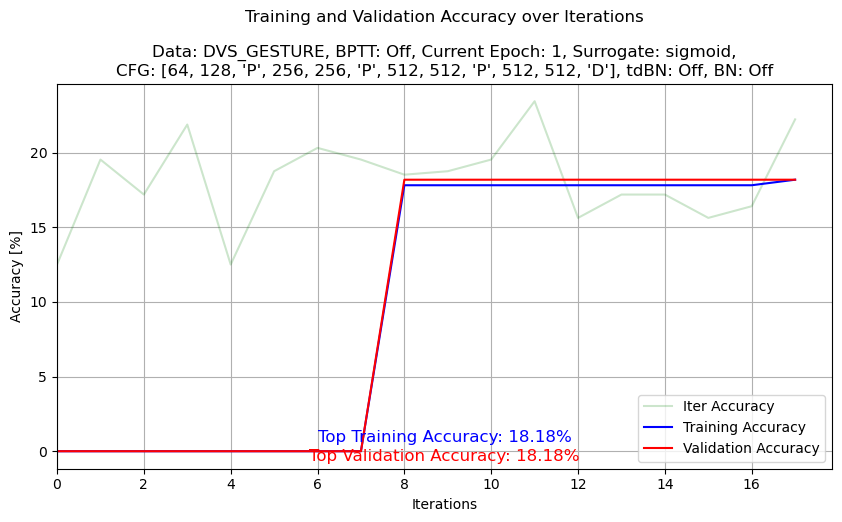

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import json




def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

### if you want to just see most recent train and val acc###########################
iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

loaded_iter_acc_array = np.load(iter_acc_file_name)*100
loaded_tr_acc_array = np.load(tr_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

top_iter_acc = np.max(loaded_iter_acc_array)
top_tr_acc = np.max(loaded_tr_acc_array)
top_val_acc = np.max(loaded_val_acc_array)

which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_iter_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # 텍스트 추가
# plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# 텍스트 추가
plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()